In [114]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from seaborn import heatmap
from sklearn.metrics import mean_squared_error,mean_absolute_error
%matplotlib inline

In [2]:
bike_rentals = pd.read_csv('bike_rental_hour.csv')
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## The descriptions for the relevant columns
* instant - A unique sequential ID number for each row
* dteday - The date of the rentals
* season - The season in which the rentals occurred
* yr - The year the rentals occurred
* mnth - The month the rentals occurred
* hr - The hour the rentals occurred
* holiday - Whether or not the day was a holiday
* weekday - The day of the week (as a number, 0 to 7)
* workingday - Whether or not the day was a working day
* weathersit - The weather (as a categorical variable)
* temp - The temperature, on a 0-1 scale
* atemp - The adjusted temperature
* hum - The humidity, on a 0-1 scale
* windspeed - The wind speed, on a 0-1 scale
* casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
* registered - The number of registered riders (people who had already signed up)
* cnt - The total number of bike rentals (casual + registered)

## Histogram of target value

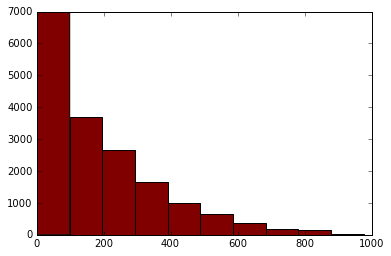

In [14]:
plt.hist(bike_rentals.cnt, color ='#800000')
plt.show()

## Heatmap of correlations among df

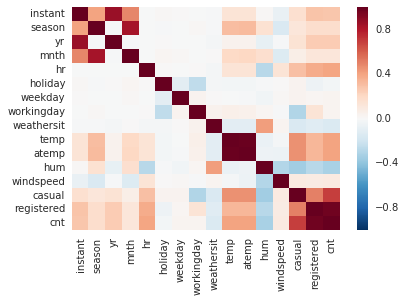

In [18]:
heatmap(bike_rentals.corr())
plt.show()

In future predictions we'll use all columns except 'casual' and 'registered'.

### Create a column with day time information

In [21]:
def day_time(row):
    if row >= 0 and row <6:
        return 4
    elif row >= 6 and row < 12:
        return 1
    elif row >= 12 and row < 18:
        return 2
    else:
        return 3
    
bike_rentals['time_label'] = bike_rentals.hr.apply(day_time)

In [26]:
bike_rentals[['time_label', 'cnt']].corr()

,time_label,cnt
time_label,1.000000,-0.378318
cnt,-0.378318,1.000000


Our purpose is prediction of quantitative value, it's a regression task. There are some metrics of errors, but I'll choose MAE, MSE. Before that we will culculate score method in RFR class (score R^2).

In [62]:
bike_rentals_shuffle = bike_rentals.sample(frac = 1,random_state=1)

In [65]:
split_size = int(np.round(.8*len(bike_rentals)))

train = bike_rentals_shuffle[:split_size]
test = bike_rentals_shuffle[split_size:]

This line will select any rows in bike_rentals that aren't found in train to be in the testing set: **bike_rentals.loc[~bike_rentals.index.isin(train.index)]**

In [70]:
bike_rentals.corr()['cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
time_label   -0.378318
Name: cnt, dtype: float64

In [125]:
columns = ['season', 'yr', 'time_label', 'weekday', 'weathersit', 'atemp', 'hum', 'windspeed']
columns_less = ['season', 'yr', 'time_label', 'weekday', 'atemp', 'hum']
target = 'cnt'

In [127]:
lr = LinearRegression()
lr.fit(train[columns_less], train[target])

train_error = mean_squared_error(train[target], lr.predict(train[columns_less]))
predictions_error = mean_squared_error(test[target], lr.predict(test[columns_less]))
print("Train rmse: ", np.sqrt(train_error),
      "\nPredictions rmse: ", np.sqrt(predictions_error),
      "\nR^2:", lr.score(test[columns_less], test[target]))

Train rmse:  139.548801582 
Predictions rmse:  137.265846241 
R^2: 0.405756635049


The quality of our model is incredibly low. R-squared ~ .4

In [142]:
rf = RandomForestRegressor(max_depth=8, max_features= 4, min_samples_leaf=18)
rf.fit(train[columns_less], train[target])

train_error = mean_squared_error(train[target], rf.predict(train[columns_less]))
predictions_error = mean_squared_error(test[target], rf.predict(test[columns_less]))

print("Train error: ", np.sqrt(train_error),
      "\nPredictions error: ", np.sqrt(predictions_error),
      "\nR^2:", rf.score(test[columns_less], test[target]))

Train error:  115.267103582 
Predictions error:  115.707391243 
R^2: 0.577757871938


Ha! We improve our model score. R-squared ~.58

Here are some potential next steps:

* Calculate additional features, such as:
    * An index combining temperature, humidity, and wind speed
* Try predicting casual and registered instead of cnt.